# Necessary Imports

In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import os

np.random.seed(42) # to allow stable runs

# To plot the pictures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. Separate the Features and label

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
# mnist['data] - 7000 images with 784 features each, 28x28 = 784. The 2D image was flattened into a single row of 784 features
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
X.shape

(70000, 784)

In [6]:
# mnist['target'] - the labels (whether the image is what number from 1-10)
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

# 2. Plots the first instance in the dataset

Saving figure 5


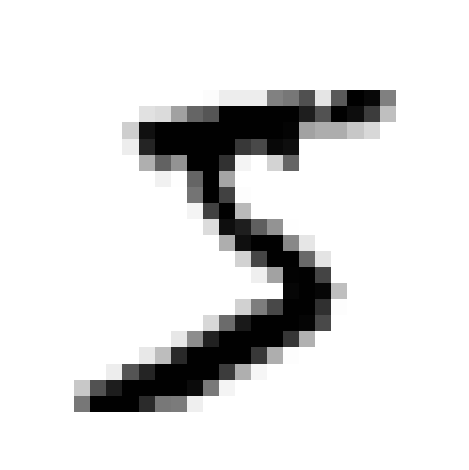

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] # a single row with 784 features
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("5")
plt.show()

In [9]:
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [10]:
y[0] # The first instance in the label column is 5

'5'

# 3. Convert label into integer type

In [11]:
y = y.astype(np.uint8)
y.dtype

dtype('uint8')

# 4. Train / test split

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
X_train.shape # 60,000 rows as train data

(60000, 784)

In [14]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [15]:
X_test.shape # 10,000 rows as test data

(10000, 784)

In [16]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

# 5. Model Training

### Converting the label data into two classes (true, false)

In [17]:
# For this binary classification, we only assume two results. Whether an instance will be five or not five
y_train_5 = (y_train == 5)
y_train_5

array([ True, False, False, ...,  True, False, False])

In [18]:
y_test_5 = (y_test == 5)
y_test_5

array([False, False, False, ..., False,  True, False])

In [19]:
y_train[y_train_5]

array([5, 5, 5, ..., 5, 5, 5], dtype=uint8)

In [20]:
import pandas as pd

unique, values = np.unique(y_train, return_counts=True)

df = {'Classes' : unique,
      'Count' : values}
df = pd.DataFrame(df)
df['% of total'] = (df['Count'] / df['Count'].sum()) * 100
df

,Classes,Count,% of total
0,0,5923,9.871667
1,1,6742,11.236667
2,2,5958,9.930000
3,3,6131,10.218333
4,4,5842,9.736667
5,5,5421,9.035000
6,6,5918,9.863333
7,7,6265,10.441667
8,8,5851,9.751667
9,9,5949,9.915000


# 5.1 Binary Classification - 5, not 5

## SGD Classifier

In [89]:
# We use SGD Classifier as our model. Stochastic Gradient Descent is great in handling large datasets
from sklearn.linear_model import SGDClassifier

# basically e.g. [1, 2, 3, ..., 784] label = True
#                [4, 5, 6, ..., 784] label = False
sgd_clf = SGDClassifier(random_state=42)

#### fit

In [ ]:
sgd_clf.fit(X_train, y_train_5) 

#### predict

In [22]:
sgd_clf.predict([some_digit])

array([ True])

### Cross validation

#### K-fold

In [23]:
from sklearn.model_selection import cross_val_score

for id, score in enumerate(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")):
    print(f'Fold {id + 1}: ', score)

Fold 1:  0.95035
Fold 2:  0.96035
Fold 3:  0.9604


#### Stratified K-Fold (Not ideal for classifiers)

In [ ]:
# Stratified Kfold allows cross-validation with equal partitions of each class in the dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Call out the function
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [25]:
# For every iteration/fold, it creates a clone of the model, and fit the model to that train data fold. 
# Then, we compute the accuracy
# by dividing the correct predictions with the total no. of predictions
i = 1
for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    # a clone classifier
    clone_clf = clone(sgd_clf)

    # train data_k
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    # test data_k
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # fit data to model
    clone_clf.fit(X_train_folds, y_train_folds)

    # predict y_hat
    y_pred = clone_clf.predict(X_test_fold)

    # How many in the y_hat == y_test_fold
    n_correct = sum(y_pred == y_test_fold)

    print(f'Fold {i}: {n_correct / len(y_pred)}')
    i += 1

Fold 1: 0.9669
Fold 2: 0.91625
Fold 3: 0.96785


#### Confusion Matrix 

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # y_hat

In [27]:
y_train_pred # of shape (60000,)

array([ True, False, False, ...,  True, False, False])

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) # remember that y_train_5 is also an array of bool values of shape (60000,)

array([[53892,   687],
       [ 1891,  3530]])

#### Precision / Recall Score

In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

In [30]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

#### Precision / Recall Tradeoff (Use when positive class is rare)

In [31]:
# We use decision function to get the score instead of a binary value 0, 1
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred # Because the score of the instance is greater than the threshold, it was classified to be true (a 5)

array([ True])

In [33]:
threshold = 8000 # if we set a high threshold, then it will classify it as false because your y_score is only 2164.220...
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [35]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

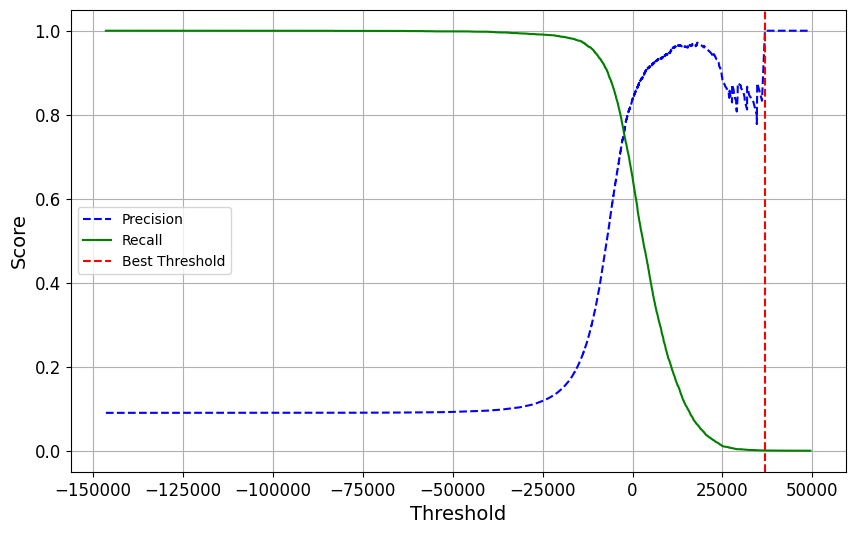

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
    best_threshold = thresholds[precisions[:-1].argmax()]
    plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [37]:
precisions

array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
       1.        ])

In [38]:
np.argmax(precisions >= 0.90) # returns the index of the highest precision in our precision curve

np.int64(57109)

In [39]:
# In this case, we want to choose a threshold that will give us a 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision # If we set the threshold to this, we will be able to get a 90% precision

np.float64(3370.0194991439557)

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [41]:
# We were able to achieve a precision score of 90%
print(f"Recall Score: {recall_score(y_train_5, y_train_pred_90)}")
print(f"Precision Score: {precision_score(y_train_5, y_train_pred_90)}")

Recall Score: 0.4799852425751706
Precision Score: 0.9000345901072293


#### ROC AUC Score (Use when positive class is not rare)

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#### F1 Score

In [44]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

## Random Forest Classifier

In [45]:
# RandomForest uses the predict_proba method of the cross_val_predict()
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

#### fit

In [46]:
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(random_state=42)

#### predict

In [88]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

### Cross Validation

##### cross val predict (predict proba)

In [47]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # proba values
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

##### cross val predict (predict)

In [48]:
y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3) # scores
y_forest_pred

array([ True, False, False, ...,  True, False, False])

#### Precision / Recall Score

In [49]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_forest_pred)

np.float64(0.9905083315756169)

In [50]:
recall_score(y_train_5, y_forest_pred)

np.float64(0.8662608374838591)

#### ROC AUC Score

In [51]:
# ROC AUC requires scores. 
# RandomForest outputs probabilities so we need to convert it into scores. 
# One way to do this is to use the proba of positive instances as scores 
y_scores_forest = y_probas_forest[:, 1]

roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

#### F1 Score

In [52]:
from sklearn.metrics import f1_score
print(f"F1 Score: {f1_score(y_train_5, y_forest_pred)}")

F1 Score: 0.9242275142688448


#### Saving our model

In [53]:
import pickle

with open('C:/Users/kgonzales21/Downloads/IE things/IE things/ML Models/Digit_Classifier.pkl'.replace('\\', '/'), 'wb') as file:
    pickle.dump(forest_clf, file)

#### Import model

In [54]:
with open('C:/Users/kgonzales21/Downloads/IE things/IE things/ML Models/Digit_Classifier.pkl', 'rb') as file:
    model = pickle.load(file)

#### Test model

In [55]:
directory = 'C:/Users/kgonzales21/Downloads/IE things/IE things/Major Projects/Data-Analysis-and-Machine-Learning/images/test'  # Replace with your directory path

In [56]:
import os
import numpy as np
from PIL import Image

def load_images_from_directory(directory, target_size=(28, 28)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize image to target size
            img_array = np.array(img).flatten()  # Flatten the 2D image into a 1D array
            img_array = 255 - img_array  # Invert the pixel values so that whites are 0
            images.append(img_array)
    return np.array(images)

images_array = load_images_from_directory(directory)

In [57]:
images_array[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  21,  16,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  32,  42,  37,  63, 118, 178, 231, 216,  36,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   4, 203, 249, 248, 255, 255, 255, 255, 255,
        91,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  32, 245, 255, 251, 221, 189, 153,
       106,  72,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  77, 255, 237,  6

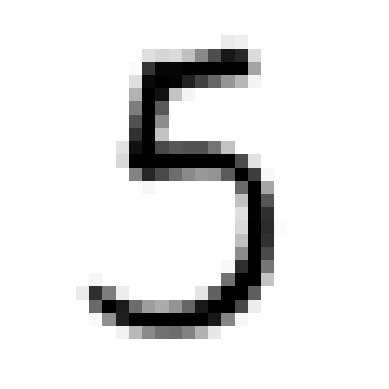

In [58]:
image = images_array[0] # a single row with 784 features
image = image.reshape(28, 28)
plt.imshow(image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [59]:
model.predict([images_array[0]]) # as you can see, the new picture is predicted correctly

array([ True])

In [60]:
model.predict_proba([images_array[0]])

array([[0.19, 0.81]])

In [61]:
images_array[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  77, 221,
       100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

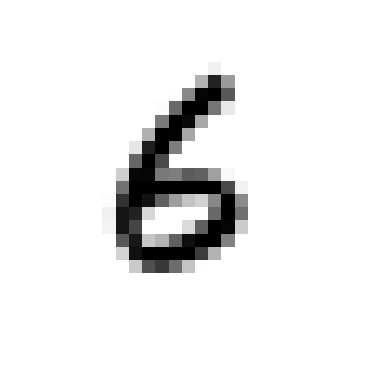

In [62]:
image = images_array[1] # a single row with 784 features. (1, 784)
image = image.reshape(28, 28)
plt.imshow(image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [63]:
model.predict([images_array[1]]) # as you can see, correctly predicted as false

array([False])

In [64]:
model.predict_proba([images_array[1]])

array([[0.97, 0.03]])

# 5.2 Multiclass Classification - 0 to n

## SGD Classifier (One Versus All)

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_clf = SGDClassifier(random_state=40)

#### fit

In [66]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=40)

#### predict

In [ ]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

#### decision function

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit]) # Returns the scores of image 1 falling to each class (0-9)
some_digit_scores

array([[-28206.21839161, -36489.76547769,  -7548.33084091,
         -1581.10692853, -14984.06283472,   1485.90912035,
        -19177.65689963, -15717.26054423, -13627.36406215,
        -15029.45563461]])

In [ ]:
np.argmax(some_digit_scores) # index 5 has the highest score, thus, the image is digit 5

np.int64(5)

#### classes

In [70]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### Cross Validation

#### cross val score

In [90]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

#### Confusion Matrix

## SGD Classifier (One versus One)

In [71]:
# SGD Classifier automatically runs OVA so in this case, we forced it to do OVO
from sklearn.multiclass import OneVsOneClassifier

In [72]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=40))

#### fit

In [73]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=40))

#### predict

In [ ]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

#### decision function

In [75]:
ovo_clf.decision_function([some_digit])

array([[ 2.66666692,  3.66666708,  5.3333328 ,  8.33333319,  1.66666687,
         9.33333318, -0.33333318,  3.66666803,  4.33333283,  6.33333234]])

#### estimators

In [76]:
len(ovo_clf.estimators_) # N x (N-1) / 2, this OVO Classifier trained 45 classifiers (0 vs. 1, 0 vs. 2...)

45

## Random Forest (no need to OVO and OVA)

#### fit

In [77]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### predict

In [ ]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

#### predict proba

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

# 5.3 Multilabel Classification - [True/False, 1/0, ...]

## K Nearest Neighbors

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)

In [91]:
y_train_large = (y_train >= 7) # instances greater than or equal to 7
y_train_odd = (y_train % 2 == 1) # instances that are odd
y_multilabel = np.c_[y_train_large, y_train_odd]

In [92]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

#### fit

In [93]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_neighbors=4, weights='distance')

#### predict

In [ ]:
knn_clf.predict([some_digit]) # Is it >= 7? False, Is it odd? True. Thus, the label is [False, True]

array([[False,  True]])

#### F1 Score

In [ ]:
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_predict, average='macro') # using macro assumes that all labels are equally important. If that's not the case, we can use "weighted" as an average method

np.float64(0.9786580239202405)